# Feature Selection

## Subset Selection

<p>Probably the most common approach to explicit feature selection is to choose a subset of $k$ features from the total set of $p$ features. The idea scenario would be to consider every possible subset of size $k$ and choose the one that has the best out-of-sample error. Although ideal in theory, in practice, there are $\binom{p}{k} = \frac{p!}{k!(p-k)!}$ possible subsets of size $k$. Testing each one is often cost prohibitive when $p$ gets large.<br><br>

<b><u>Forward Stepwise Selection</u></b><br>
Forward stepwise selection uses a greedy procedure to learn a good subset of $k$ features (though not guaranteed to be the "best" subset). The procedure goes as follows:<br>
<ul>
    <li>1. Initialize: Curr_Best_Subset = { } (i.e., just the intercept)</li>
    <li>2. Loop through each feature $j$:</li>
        <ul>
            <li> a. Add the feature to the current best subset, train a model</li>
            <li> b. Get out-of-sample error on the model trained with Curr_Best_Subset+feature $j$</li>
        </ul>
    <li>3. Choose the feature with the best out-of-sample improvement in error </li>
    <li>4. Add this best feature to Curr_Best_Subset, and log the out-of-sample error</li>
    <li>5. Repeat steps 2 - 4 until stopping criterion is met.</li>
</ul><br>
Some possible stopping criteria are:<br>
<ul>
    <li>Stop at a pre-defined $k$</li>
    <li>Stop when (Performance: Best $k$ - Performance: Best $k-1$)$<\delta$ </li>
    <li>Same as above, but using a 1-std error rule or a t-test to compare best $k$ vs. best $k-1$</li>
</ul><br>
It might not always make sense or be optimal to choose $k$ in advance. The other two stopping criteria amount to continually adding features until the feature does not improve the model, either in an absolute sense or using some statistical test to compare the difference between cross-validated means.<br>



The following code shows how this can be done. We'll use the churn prediction data. For a metric, let's assume we care the most about having a good estimate of $P(Y|X)$, so we'll use logistic regression with log-loss as our feature selection criterion. Again, the log-loss is defined as:<br><br>
<center>$logloss = -\frac{1}{n} \sum\limits_{i=1}^n \: y_i*log(p_i)+(1-y_i)*log(1-p_i)$</center><br>
We'll also use the last stopping criteria shown above.

</p>

In [16]:
#Load the data. Not much prep is need since its a clean dataset
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import sys
import course_utils as bd
from sklearn import linear_model


f = '../data/Cell2Cell_data.csv'
dat=pd.read_csv(f, header=0, sep=',')
dat['r'] = np.random.random(dat.shape[0])
dat = dat.sort_values(by='r').reset_index(drop=True)
dat = dat.drop('r', axis=1)

train, test = bd.trainTest(dat, 0.5)
lab = 'churndep'


In [17]:
from sklearn.model_selection import KFold


def runXVal_LogLoss(cv, X_sub, Y_tr):
    '''
    Runs LR cross validation with no regularization, returns mean and standard error of mean
    '''
    ll = []; 
    for train_index, test_index in cv.split(X_sub):
        X_tr_f = X_sub.iloc[train_index]
        X_va_f = X_sub.iloc[test_index]
        Y_tr_f = Y_tr.iloc[train_index]
        Y_va_f = Y_tr.iloc[test_index]

        lr = linear_model.LogisticRegression()
        lr.fit(X_tr_f, Y_tr_f)
        P = lr.predict_proba(X_va_f)[:,1]
        
        ll.append(-1*(((Y_va_f==1)*np.log(P)+(Y_va_f==0)*np.log(1-P)).mean()))

    return [np.array(ll).mean(), np.array(ll).std()/np.sqrt(len(ll))]
        
def LrForward_LogLoss(X_tr, Y_tr, cv):
    '''
    Runs cross-validated stepwise selection
    Does not pick the best features, but returns data
    Returns a dictionary that shows at each k: [feature set], x-validated mean, x-validated var 
    For each loop, chooses the feature with best mean+1stderr
    '''
    results = {}
    curr_best = set([])
    cand_list = set(X_tr.columns.values)
    k = 1
    
    while (len(cand_list)>0):
        best_mu = 10**10; best_serr = 10**10; 
        for f in cand_list:
            use_x = list(curr_best)+[f]
            mu, serr = runXVal_LogLoss(cv, X_tr[use_x], Y_tr)
            if ((mu + serr) < (best_mu + best_serr)):
                best_mu = mu
                best_serr = serr
                best_f = f
        curr_best.add(best_f) #Add the best feature to the curr_best_set
        cand_list = cand_list.difference(curr_best) #Remove the best feature from the candidate set
        results[k] = [list(curr_best), best_mu, best_serr]
        k+=1
        
    return results
            

In [18]:
#Run the forward selection
cv = KFold(n_splits=10)
r = LrForward_LogLoss(train.drop(lab,1), train[lab], cv)

<p>


</p>

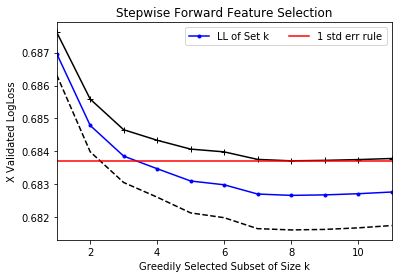

In [19]:
#Now plot the incremental results
ks = []; mus = []; serrs = [];
for i in range(len(r.keys())):
    ks.append(i+1)
    mus.append(r[i+1][1])
    serrs.append(r[i+1][2])

    
best_1serr = min(np.array(mus) + np.array(serrs))
plt.clf()
plt.plot(ks, mus, 'b.-', label = 'LL of Set k')
plt.plot(ks, np.array(mus) + np.array(serrs), 'k+-')
plt.plot(ks, np.array(mus) - np.array(serrs), 'k--')
plt.plot(ks, np.ones(len(ks))*best_1serr, 'r', label ='1 std err rule')

plt.xlim([1,11])

plt.title('Stepwise Forward Feature Selection')
plt.xlabel('Greedily Selected Subset of Size k')
plt.ylabel('X Validated LogLoss')
    
plt.legend(loc=1, ncol=2)
plt.show()

<p>The above plot will support any of the stopping criteria defined above. Assuming we haven't predefined $k$, we might choose $k=7$, as that is where the error really seems to plateau. Additionally, we could be more conservative. The red line shows the min value of (mean+1 std error). Any value of $k$ that is less than this value is statistically the same as the $k$ with the lowest mean error. If we were using that rule, we'd potentially stop at $k=3$.<br><br>
</p>

## SVD Based Dimensionality Reduction

<p>Another way to bring the learning down to $k$ features is to find a projection matrix that produces a rank-$k$ approximation of our training data $X$. The best way to get a low-rank approximation, from a signal preservation perspective, is by the use of the Singular Value Decomposition. A review of the SVD can be found here:<br><br>
http://nbviewer.ipython.org/github/briandalessandro/DataScienceCourse/blob/master/ipython/Lecture3_PhotoSVD.ipynb
<br><br>
We'll put it to work here by doing the following:
<ul>
    <li>Decomposing our training data</li>
    <li>For each rank-k approximation of X, get cross-validated error</li>
    <li>Compare this error to the Stepwise Forward Feature Selection above</li></ul><br>
The scale of the features influences the spectrum of the singular values, so we'll normalize the feature so they all have the same scale.
</p>    

In [20]:
import numpy as np
import math
from sklearn import linear_model
from sklearn.preprocessing import scale


f = '../data/Cell2Cell_data.csv'

X_train = train.drop(lab, 1)
X_test = test.drop(lab, 1)
Y_train = train[lab]
Y_test = test[lab]

X_train_norm = pd.DataFrame(scale(X_train, axis=0, with_mean=True, with_std=True, copy=True), columns = X_train.columns.values)


<p>Now let's decompose the training data.</p>

In [21]:
U, sig, Vt = np.linalg.svd(X_train_norm)

<p>Out of curiosity, let's plot the spectrum to get a sense of how independent the features are.

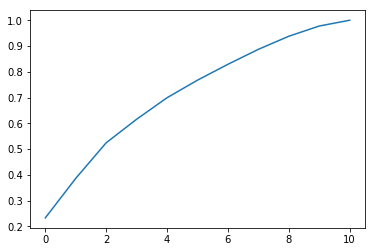

In [22]:
plt.plot(np.cumsum(sig**2)/np.sum(sig**2))
plt.show()

<p>We can see above that the first 5 or 6 singular values account for 70-80% of the sum of squares of our data. Now let's see how a rank-$k$ approximation does in cross-validation.
</p>

In [23]:
def LrRankK_LogLoss(U, sig, Vt, Y_tr, cv):
    '''
    Runs cross-validation on each rank k approximation
    '''
    results = {}
    
    for k in range(len(sig)):
        X_k = pd.DataFrame(np.matrix(U[:, :k+1]) * np.diag(sig[:k+1]))
        mu, serr = runXVal_LogLoss(cv, X_k, Y_tr)
        results[k+1] = [mu, serr]
        
        
    return results

In [24]:
r_svd = LrRankK_LogLoss(U, sig, Vt, Y_train, cv)

<p>Now let's plot the results. We'll also plot it with the stepwise forward selection results above.
</p>

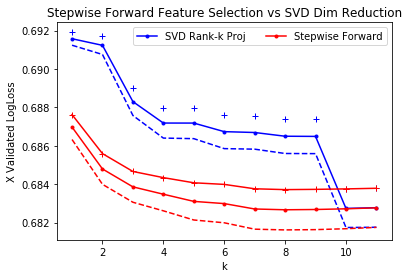

In [25]:
plt.clf()

k_svd = []
mu_svd = []
serr_svd = []

for i in range(len(r_svd.keys())):
    k_svd.append(i+1)
    mu_svd.append(r_svd[i+1][0])
    serr_svd.append(r_svd[i+1][1])
    
plt.plot(k_svd, mu_svd, 'b.-', label = 'SVD Rank-k Proj')
plt.plot(k_svd, np.array(mu_svd)+np.array(serr_svd), 'b+')
plt.plot(k_svd, np.array(mu_svd)-np.array(serr_svd), 'b--')


plt.plot(ks, mus, 'r.-', label = 'Stepwise Forward')
plt.plot(ks, np.array(mus) + np.array(serrs), 'r+-')
plt.plot(ks, np.array(mus) - np.array(serrs), 'r--')

plt.legend(loc=1, ncol=2)

plt.title('Stepwise Forward Feature Selection vs SVD Dim Reduction')
plt.xlabel('k')
plt.ylabel('X Validated LogLoss')

plt.show()


<p>This is a very interesting plot. We can see that SVD approach does almost universally worse than the stepwise approach. Its not until we get to the last two features do we see them equal each other. <br><br>
My interpretation of this is that the SVD approach does not reduce the feature space with the outcome or learning task in mind. It is purely untangling the covariance structure of the matrix $X$. It is quite possible (based on the evidence above), that the most predictive features corresponded to the lowest singular values. That is why we don't see a large reduction in the cross-validated error until the last few columns are added into the matrix.<br><br>

This is not to say or prove that dimensionality reduction with SVD is a generally inferior approach. Because the matrix $X$ is dense and not very high dimensional, the SVD approach just might not be appropriate here. It is also slower, as the cost of generating the SVD isn't always cheap.


</p>